In [1]:
from netCDF4 import Dataset
import numpy as np
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
def filter_grid_point(df, lat, lon):
    filtered_df = df[(df['Lat']==lat) & (df['Lon']==lon)]
    if not filtered_df.empty:
        rain = filtered_df.iloc[0]['Rain']
        return rain
    else:
        return 0.0

In [3]:
def get_netcdf_rfield(netcdf_file,grid_lon, grid_lat):
    nnc_fid = Dataset(netcdf_file, mode='r')
    time_unit_info = nnc_fid.variables['XTIME'].description
    time_unit_info_list = time_unit_info.split('since ')

    lats = nnc_fid.variables['XLAT'][0, :, 0]
    lons = nnc_fid.variables['XLONG'][0, 0, :]

    lon_min = lons[0].item()
    lat_min = lats[0].item()
    lon_max = lons[-1].item()
    lat_max = lats[-1].item()

    lat_inds = np.where((lats >= lat_min) & (lats <= lat_max))
    lon_inds = np.where((lons >= lon_min) & (lons <= lon_max))

    rainnc = nnc_fid.variables['RAINNC'][:, lat_inds[0], lon_inds[0]]
    times = nnc_fid.variables['XTIME'][:]
    nnc_fid.close()
    
    #diff = get_per_time_slot_values(rainnc)
    diff = rainnc
    width = len(lons)
    height = len(lats)
    
    plot_list = []
    
    for i in range(len(diff)):
        ts_time = datetime.strptime(time_unit_info_list[1], '%Y-%m-%d %H:%M:%S') + timedelta(minutes=times[i].item())
        t = datetime_utc_to_lk(ts_time, shift_mins=0)
        timestamp = t.strftime('%Y-%m-%d %H-%M-00')
        ts_list = []
        for y in range(height):
            for x in range(width):
                lat = float('%.6f' % lats[y])
                lon = float('%.6f' % lons[x])
                rain = '%.3f' % float(diff[i, y, x])
                ts_list.append([lon, lat, rain])
        ts_df = pd.DataFrame(ts_list, columns=['Lon', 'Lat', 'Rain'])
        grid_point_rain = float(filter_grid_point(ts_df, grid_lat, grid_lon))
        plot_list.append([timestamp, grid_point_rain])
    return plot_list

In [4]:
def plot_grid_point_df(rain_source, netcdf_file,grid_lon, grid_lat):
    plot_list = get_netcdf_rfield(netcdf_file,grid_lon, grid_lat)
    if len(plot_list)>0:
        df = pd.DataFrame(plot_list, columns=['Time',rain_source])
        return df
    else:
        return None

In [5]:
def plot_grid_point_df_list(rain_source_list, netcdf_file_list,grid_lon, grid_lat):
    df_list = []
    i = 0
    for netcdf_file in netcdf_file_list:
        df = plot_grid_point_df(rain_source_list[i], netcdf_file,grid_lon, grid_lat)
        i+=1
        if df is not None:
            df_list.append(df)
    return df_list

In [9]:
def get_per_time_slot_values(prcp):
    per_interval_prcp = (prcp[1:] - prcp[:-1])
    return per_interval_prcp

def datetime_utc_to_lk(timestamp_utc, shift_mins=0):
    return timestamp_utc + timedelta(hours=5, minutes=30 + shift_mins)

In [10]:
netcdf_files = ['/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/wrf_A_d03_RAINNC.nc', 
                '/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/wrf_C_d03_RAINNC.nc', 
                '/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/wrf_E_d03_RAINNC.nc',
                '/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/wrf_SE_d03_RAINNC.nc']
rain_sources = ['A','C','E','SE']

In [11]:
def plot_models_rfields_of_grid(model_list, netcdf_files, lon, lat):
    df_list = plot_grid_point_df_list(model_list, netcdf_files,lon, lat)
    plot_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time'), df_list)
    plot_df.plot(x='Time', y=model_list, kind='line', figsize=(20,10), grid=True)

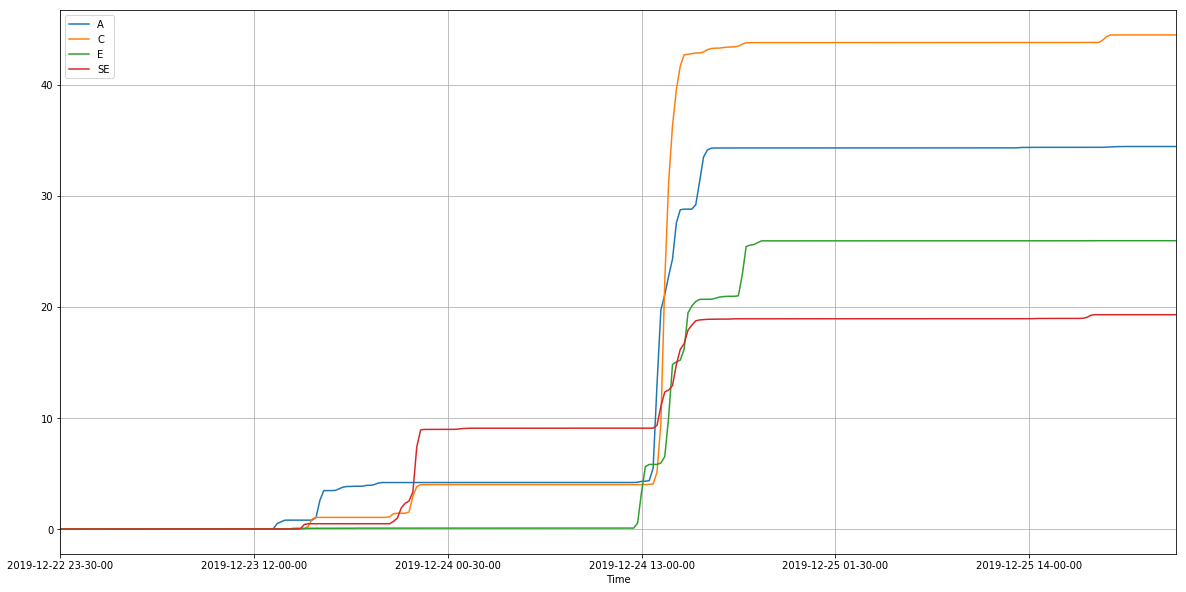

In [12]:
plot_models_rfields_of_grid(rain_sources, netcdf_files, 80.556168, 7.102936)